<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/5_Find_Best_Traffic_Flow_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In this code file, we use only the traffic flow data that were generated under the SPQ rules.

In [29]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [30]:
# Access google drive location
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_SPQ.csv'

**Prepare the dataset**

In [32]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [33]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-06-10 04:30:04,2008-06-10 05:00:04,2008-06-10 05:30:04,2008-06-10 06:00:04,2008-06-10 06:30:04,2008-06-10 07:00:04,2008-06-10 07:30:04,2008-06-10 08:00:04,2008-06-10 08:30:04,2008-06-10 09:00:04
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,11,7,6,3,0,1,...,0,0,0,0,0,0,2,2,0,0


In [34]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

In [35]:
# Convert 'Path' column to numerical
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [36]:
# Print dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
67,108,5,0,20,2008-05-17 10:00:04,0
167,108,5,0,20,2008-05-17 10:30:04,0
267,108,5,0,20,2008-05-17 11:00:04,0
367,108,5,0,20,2008-05-17 11:30:04,1
467,108,5,0,20,2008-05-17 12:00:04,0
...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0
114735,168,547,99,2,2008-06-10 07:30:04,0
114835,168,547,99,2,2008-06-10 08:00:04,1
114935,168,547,99,2,2008-06-10 08:30:04,0


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [37]:
### Extract timestamp information to different columns ###
traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###
traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [38]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [39]:
# Print traffic_flow dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,dayofweek,day,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
67,108,5,0,20,2008-05-17 10:00:04,0,10,5,17,0,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
167,108,5,0,20,2008-05-17 10:30:04,0,10,5,17,30,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
267,108,5,0,20,2008-05-17 11:00:04,0,11,5,17,0,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
367,108,5,0,20,2008-05-17 11:30:04,1,11,5,17,30,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
467,108,5,0,20,2008-05-17 12:00:04,0,12,5,17,0,1.224647e-16,-1.000000,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0,7,1,10,0,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114735,168,547,99,2,2008-06-10 07:30:04,0,7,1,10,30,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3
114835,168,547,99,2,2008-06-10 08:00:04,1,8,1,10,0,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114935,168,547,99,2,2008-06-10 08:30:04,0,8,1,10,30,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3


In [40]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-06-10 09:00:04


#### **Make Visualizations**


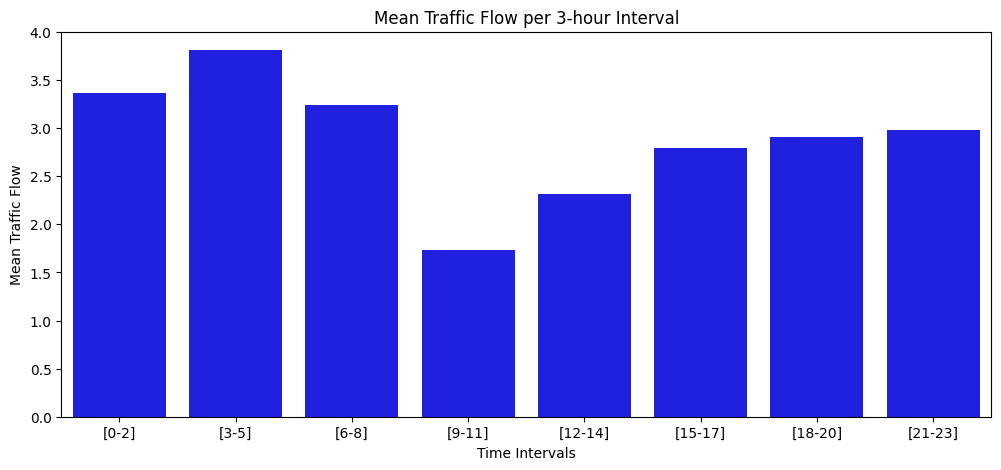

In [41]:
# Group by 3hour_interval and calculate the mean of the traffic flow
grouped_df = traffic_flow['Traffic Flow'].groupby(traffic_flow['3hour_interval']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Define the intervals (use strings for easy understanding)
intervals = ['[0-2]','[3-5]','[6-8]','[9-11]','[12-14]','[15-17]','[18-20]','[21-23]']
grouped_df['Hour Interval'] = intervals

# Create a plot to view the results
plt.figure(figsize=(12,5))
sns.barplot(grouped_df, x='Hour Interval', y='Traffic Flow', color='blue')
plt.xlabel('Time Intervals')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per 3-hour Interval')

# Show graph
plt.show()

The graph suggests that traffic flow peaks during morning and evening hours, while it tends to be lower during noon.

Text(0.5, 1.0, 'Mean Traffic Flow per Day of Week')

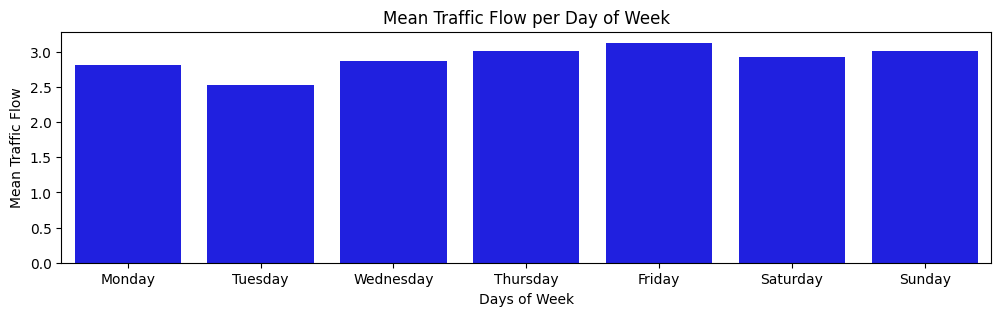

In [42]:
# Group by dayofweek and calculate the mean of the traffic flow
grouped_df = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['dayofweek']).mean())
grouped_df['Days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(grouped_df,x='Days',y='Traffic Flow',color='blue')
plt.xlabel('Days of Week')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per Day of Week')

Text(0.5, 1.0, 'Mean Traffic Flow during  Memorial Day (26th of May 2008)')

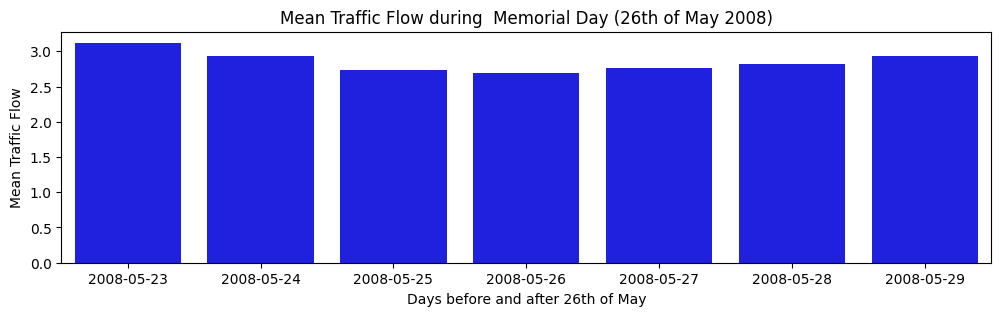

In [43]:
# Select data within the specified date range
select_data = traffic_flow[(traffic_flow['Time Column'] >= '2008-05-23') & (traffic_flow['Time Column'] < '2008-05-30')]
# Extract the date portion from the 'Time Column' and create a new 'Date' column
select_data['Date'] = select_data['Time Column'].dt.date
# Create a DataFrame by grouping 'Traffic Flow' by 'Date' and calculating the sum
select_data = pd.DataFrame(select_data['Traffic Flow'].groupby(select_data['Date']).mean())

# Create a plot to visualize the results
plt.figure(figsize=(12, 3))  # Set the size of the plot figure
sns.barplot(data=select_data, x=select_data.index, y='Traffic Flow',color='blue')
plt.xlabel('Days before and after 26th of May')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow during  Memorial Day (26th of May 2008)')

According to the calendar, Memorial Day in the United States fell on May 26, 2008. The graph above indicates that on this particular day, there was a decrease in traffic flow, while the subsequent days showed higher traffic flow.

On Memorial Day, many businesses are closed, schools may be out, and people often take the opportunity to engage in various leisure activities or travel. As a result, there tends to be a decrease in local commuting and traffic flow on that specific day compared to the surrounding days.

<Axes: >

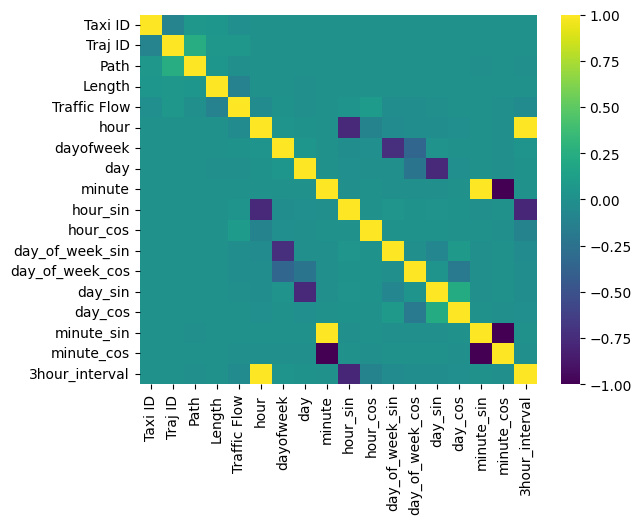

In [44]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(traffic_flow.corr(),cmap='viridis')

In [45]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Traffic Flow', 'hour', 'dayofweek', 'day', 'minute']

#### **Find the Optimum Sliding Window Length**

In [46]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [47]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [48]:
# Import libraries to use the LSTM Neural Network algorithm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

In [49]:
# Use Regression Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [50]:
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

##### Sliding Window Length Equals to 2

In [51]:
# Define Window Length
optimum_lookback = 2

In [52]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [53]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [54]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [55]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

In [56]:
features

Index(['Record 1(t-2)', 'Record 1(t-1)', 'Taxi ID', 'Traj ID', 'Path',
       'Length', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'day_sin', 'day_cos', 'minute_sin', 'minute_cos', '3hour_interval',
       'rolling_mean', 'rolling_var'],
      dtype='object')

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [57]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [58]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.62397	validation_1-rmse:4.43400
[1]	validation_0-rmse:4.30223	validation_1-rmse:4.11935
[2]	validation_0-rmse:4.02191	validation_1-rmse:3.84597
[3]	validation_0-rmse:3.77606	validation_1-rmse:3.60309
[4]	validation_0-rmse:3.56254	validation_1-rmse:3.39454
[5]	validation_0-rmse:3.38910	validation_1-rmse:3.22878
[6]	validation_0-rmse:3.23113	validation_1-rmse:3.07600
[7]	validation_0-rmse:3.09592	validation_1-rmse:2.94088
[8]	validation_0-rmse:2.98459	validation_1-rmse:2.83206
[9]	validation_0-rmse:2.88666	validation_1-rmse:2.73648
[10]	validation_0-rmse:2.80700	validation_1-rmse:2.65795
[11]	validation_0-rmse:2.73661	validation_1-rmse:2.58683
[12]	validation_0-rmse:2.68108	validation_1-rmse:2.53278
[13]	validation_0-rmse:2.63172	validation_1-rmse:2.48435
[14]	validation_0-rmse:2.59226	validation_1-rmse:2.44600
[15]	validation_0-rmse:2.55751	validation_1-rmse:2.41058
[16]	validation_0-rmse:2.53057	validation_1-rmse:2.38397
[17]	validation_0-rmse:2.50604	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [59]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [60]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [61]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1964961922498918
RMSE score: 2.160230255889692


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [62]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [63]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [64]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [65]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [66]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [67]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 9s 23ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 3/50
100/100 [==============================] - 5s 53ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 6/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 7/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 10/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0014 - val_los

In [68]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

354/354 [==============================] - 4s 12ms/step - loss: 0.0019
Test Loss: 0.001948219258338213


In [69]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

354/354 [==============================] - 5s 12ms/step


Evaluate the LSTM model

In [70]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.2930482374698715
RMSE LSTM score: 2.25107090058915


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [71]:
# Create dataframe with scores (length == 2)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [72]:
scores # length is 2

,Model,RMSE Score,MAE Score
0,XGBoost,2.160230,1.196496
1,LSTM,2.251071,1.293048


In [73]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [74]:
# Save the LSTM model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equals to 3

In [75]:
# Define Window Length
optimum_lookback = 3

In [76]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [77]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [78]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [79]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [80]:
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63403	validation_1-rmse:4.44936
[1]	validation_0-rmse:4.31652	validation_1-rmse:4.14251
[2]	validation_0-rmse:4.05401	validation_1-rmse:3.89287
[3]	validation_0-rmse:3.81163	validation_1-rmse:3.65375
[4]	validation_0-rmse:3.60011	validation_1-rmse:3.44385
[5]	validation_0-rmse:3.41696	validation_1-rmse:3.26245
[6]	validation_0-rmse:3.25698	validation_1-rmse:3.10630
[7]	validation_0-rmse:3.12709	validation_1-rmse:2.98305
[8]	validation_0-rmse:3.01017	validation_1-rmse:2.86699
[9]	validation_0-rmse:2.90802	validation_1-rmse:2.76687
[10]	validation_0-rmse:2.82222	validation_1-rmse:2.68331
[11]	validation_0-rmse:2.74927	validation_1-rmse:2.60958
[12]	validation_0-rmse:2.69064	validation_1-rmse:2.55124
[13]	validation_0-rmse:2.64037	validation_1-rmse:2.50149
[14]	validation_0-rmse:2.59534	validation_1-rmse:2.45781
[15]	validation_0-rmse:2.55995	validation_1-rmse:2.42446
[16]	validation_0-rmse:2.52789	validation_1-rmse:2.39068
[17]	validation_0-rmse:2.50039	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [81]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.62908	validation_1-rmse:4.46132
[1]	validation_0-rmse:4.31309	validation_1-rmse:4.14995
[2]	validation_0-rmse:4.03403	validation_1-rmse:3.87935
[3]	validation_0-rmse:3.79252	validation_1-rmse:3.64015
[4]	validation_0-rmse:3.58157	validation_1-rmse:3.42990
[5]	validation_0-rmse:3.39778	validation_1-rmse:3.25073
[6]	validation_0-rmse:3.24012	validation_1-rmse:3.09144
[7]	validation_0-rmse:3.10446	validation_1-rmse:2.95831
[8]	validation_0-rmse:2.98920	validation_1-rmse:2.84384
[9]	validation_0-rmse:2.88943	validation_1-rmse:2.74507
[10]	validation_0-rmse:2.80511	validation_1-rmse:2.66202
[11]	validation_0-rmse:2.73187	validation_1-rmse:2.58899
[12]	validation_0-rmse:2.67099	validation_1-rmse:2.52736
[13]	validation_0-rmse:2.61863	validation_1-rmse:2.47946
[14]	validation_0-rmse:2.57405	validation_1-rmse:2.43614
[15]	validation_0-rmse:2.53720	validation_1-rmse:2.39939
[16]	validation_0-rmse:2.50555	validation_1-rmse:2.36851
[17]	validation_0-rmse:2.47865	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [82]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [83]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1695527460404784
RMSE score: 2.1604068673454138


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [84]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [85]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [86]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [87]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [88]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [89]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 6s 13ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 2/50
100/100 [==============================] - 1s 7ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 6/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 7/50
100/100 [==============================] - 5s 54ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 10/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0013 - val_loss: 

In [90]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

350/350 [==============================] - 5s 14ms/step - loss: 0.0019
Test Loss: 0.001917406334541738


In [91]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

350/350 [==============================] - 5s 12ms/step


Evaluate the LSTM model

In [92]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.2775740337132344
RMSE LSTM score: 2.233198042680704


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [93]:
# Create dataframe with scores (length == 3)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [94]:
scores # length is 3

,Model,RMSE Score,MAE Score
0,XGBoost,2.160407,1.169553
1,LSTM,2.233198,1.277574


In [95]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [96]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equals to 4

In [97]:
optimum_lookback = 4

In [98]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [99]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [100]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [101]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [102]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63529	validation_1-rmse:4.44428
[1]	validation_0-rmse:4.32004	validation_1-rmse:4.13775
[2]	validation_0-rmse:4.05839	validation_1-rmse:3.89045
[3]	validation_0-rmse:3.81683	validation_1-rmse:3.65500
[4]	validation_0-rmse:3.60691	validation_1-rmse:3.44747
[5]	validation_0-rmse:3.42373	validation_1-rmse:3.26802
[6]	validation_0-rmse:3.26624	validation_1-rmse:3.11356
[7]	validation_0-rmse:3.13544	validation_1-rmse:2.98871
[8]	validation_0-rmse:3.01723	validation_1-rmse:2.87307
[9]	validation_0-rmse:2.91460	validation_1-rmse:2.77321
[10]	validation_0-rmse:2.82929	validation_1-rmse:2.68811
[11]	validation_0-rmse:2.76105	validation_1-rmse:2.62127
[12]	validation_0-rmse:2.69858	validation_1-rmse:2.55733
[13]	validation_0-rmse:2.64756	validation_1-rmse:2.50768
[14]	validation_0-rmse:2.60181	validation_1-rmse:2.46240
[15]	validation_0-rmse:2.56297	validation_1-rmse:2.42351
[16]	validation_0-rmse:2.52934	validation_1-rmse:2.38970
[17]	validation_0-rmse:2.50325	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [103]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.63104	validation_1-rmse:4.45731
[1]	validation_0-rmse:4.31592	validation_1-rmse:4.15232
[2]	validation_0-rmse:4.04032	validation_1-rmse:3.88657
[3]	validation_0-rmse:3.79997	validation_1-rmse:3.64732
[4]	validation_0-rmse:3.58896	validation_1-rmse:3.44008
[5]	validation_0-rmse:3.40680	validation_1-rmse:3.25774
[6]	validation_0-rmse:3.24893	validation_1-rmse:3.10241
[7]	validation_0-rmse:3.11316	validation_1-rmse:2.96965
[8]	validation_0-rmse:2.99567	validation_1-rmse:2.85537
[9]	validation_0-rmse:2.89440	validation_1-rmse:2.75541
[10]	validation_0-rmse:2.80943	validation_1-rmse:2.66983
[11]	validation_0-rmse:2.73716	validation_1-rmse:2.59824
[12]	validation_0-rmse:2.67550	validation_1-rmse:2.53709
[13]	validation_0-rmse:2.62212	validation_1-rmse:2.48666
[14]	validation_0-rmse:2.57744	validation_1-rmse:2.44068
[15]	validation_0-rmse:2.53942	validation_1-rmse:2.40280
[16]	validation_0-rmse:2.50759	validation_1-rmse:2.37065
[17]	validation_0-rmse:2.48021	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [104]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [105]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.15599001043301
RMSE score: 2.1533747036536144


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [106]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [107]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [108]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [109]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [110]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [111]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 9s 39ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/50
100/100 [==============================] - 5s 55ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 6/50
100/100 [==============================] - 6s 60ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 7/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 8/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/50
100/100 [==============================] - 6s 62ms/step - loss: 0.0013 - val_los

In [112]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

347/347 [==============================] - 3s 10ms/step - loss: 0.0018
Test Loss: 0.0018290986772626638


In [113]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

347/347 [==============================] - 3s 7ms/step


Evaluate the LSTM model

In [114]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.1871628137013397
RMSE LSTM score: 2.181165907485143


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [115]:
# Create dataframe with scores (length == 4)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [116]:
scores # length is 4

,Model,RMSE Score,MAE Score
0,XGBoost,2.153375,1.155990
1,LSTM,2.181166,1.187163


In [117]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [118]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length equals to 5

In [119]:
optimum_lookback = 5

In [120]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [121]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [122]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [123]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [124]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63615	validation_1-rmse:4.44300
[1]	validation_0-rmse:4.32056	validation_1-rmse:4.13834
[2]	validation_0-rmse:4.05912	validation_1-rmse:3.89099
[3]	validation_0-rmse:3.81792	validation_1-rmse:3.65509
[4]	validation_0-rmse:3.60832	validation_1-rmse:3.44785
[5]	validation_0-rmse:3.42509	validation_1-rmse:3.26998
[6]	validation_0-rmse:3.27338	validation_1-rmse:3.12577
[7]	validation_0-rmse:3.13636	validation_1-rmse:2.99020
[8]	validation_0-rmse:3.01825	validation_1-rmse:2.87319
[9]	validation_0-rmse:2.91717	validation_1-rmse:2.77373
[10]	validation_0-rmse:2.83730	validation_1-rmse:2.69436
[11]	validation_0-rmse:2.76234	validation_1-rmse:2.61891
[12]	validation_0-rmse:2.69963	validation_1-rmse:2.55438
[13]	validation_0-rmse:2.64916	validation_1-rmse:2.50559
[14]	validation_0-rmse:2.60663	validation_1-rmse:2.46460
[15]	validation_0-rmse:2.56814	validation_1-rmse:2.42518
[16]	validation_0-rmse:2.53462	validation_1-rmse:2.39088
[17]	validation_0-rmse:2.50640	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [125]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.63137	validation_1-rmse:4.45565
[1]	validation_0-rmse:4.31624	validation_1-rmse:4.15229
[2]	validation_0-rmse:4.04041	validation_1-rmse:3.88594
[3]	validation_0-rmse:3.80030	validation_1-rmse:3.64769
[4]	validation_0-rmse:3.58860	validation_1-rmse:3.44092
[5]	validation_0-rmse:3.40654	validation_1-rmse:3.25897
[6]	validation_0-rmse:3.24846	validation_1-rmse:3.10510
[7]	validation_0-rmse:3.11170	validation_1-rmse:2.97026
[8]	validation_0-rmse:2.99505	validation_1-rmse:2.85269
[9]	validation_0-rmse:2.89505	validation_1-rmse:2.75081
[10]	validation_0-rmse:2.80850	validation_1-rmse:2.66456
[11]	validation_0-rmse:2.73666	validation_1-rmse:2.59051
[12]	validation_0-rmse:2.67551	validation_1-rmse:2.52994
[13]	validation_0-rmse:2.62356	validation_1-rmse:2.47858
[14]	validation_0-rmse:2.57891	validation_1-rmse:2.43489
[15]	validation_0-rmse:2.54048	validation_1-rmse:2.39640
[16]	validation_0-rmse:2.50816	validation_1-rmse:2.36526
[17]	validation_0-rmse:2.48070	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [126]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [127]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1467517032648056
RMSE score: 2.1414630671270434


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [128]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [129]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [130]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [131]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [132]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [133]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 7s 28ms/step - loss: 0.0052 - val_loss: 0.0088
Epoch 2/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 3/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/50
100/100 [==============================] - 5s 53ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 5/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 6/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 10/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0012 - val_los

In [134]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

344/344 [==============================] - 4s 13ms/step - loss: 0.0019
Test Loss: 0.0019466625526547432


In [135]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

344/344 [==============================] - 6s 16ms/step


Evaluate the LSTM model

In [136]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.2652413540672172
RMSE LSTM score: 2.250170564710512


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [137]:
# Create dataframe with scores (length == 5)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [138]:
scores # length is 5

,Model,RMSE Score,MAE Score
0,XGBoost,2.141463,1.146752
1,LSTM,2.250171,1.265241


In [139]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [140]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")

##### Sliding Window Length Equal to 6

In [141]:
optimum_lookback = 6

In [142]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [143]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [144]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [145]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [146]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:4.63531	validation_1-rmse:4.42579
[1]	validation_0-rmse:4.32024	validation_1-rmse:4.12145
[2]	validation_0-rmse:4.05882	validation_1-rmse:3.87439
[3]	validation_0-rmse:3.81747	validation_1-rmse:3.64117
[4]	validation_0-rmse:3.60794	validation_1-rmse:3.43480
[5]	validation_0-rmse:3.42476	validation_1-rmse:3.25669
[6]	validation_0-rmse:3.27324	validation_1-rmse:3.11258
[7]	validation_0-rmse:3.13685	validation_1-rmse:2.97805
[8]	validation_0-rmse:3.01861	validation_1-rmse:2.86073
[9]	validation_0-rmse:2.91745	validation_1-rmse:2.76064
[10]	validation_0-rmse:2.83379	validation_1-rmse:2.67862
[11]	validation_0-rmse:2.76053	validation_1-rmse:2.60371
[12]	validation_0-rmse:2.70198	validation_1-rmse:2.54731
[13]	validation_0-rmse:2.64757	validation_1-rmse:2.49366
[14]	validation_0-rmse:2.60544	validation_1-rmse:2.45158
[15]	validation_0-rmse:2.56652	validation_1-rmse:2.41322
[16]	validation_0-rmse:2.53595	validation_1-rmse:2.38510
[17]	validation_0-rmse:2.50743	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [147]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:4.63109	validation_1-rmse:4.44007
[1]	validation_0-rmse:4.31621	validation_1-rmse:4.13706
[2]	validation_0-rmse:4.04087	validation_1-rmse:3.87137
[3]	validation_0-rmse:3.80099	validation_1-rmse:3.63564
[4]	validation_0-rmse:3.59035	validation_1-rmse:3.43041
[5]	validation_0-rmse:3.40833	validation_1-rmse:3.24823
[6]	validation_0-rmse:3.25031	validation_1-rmse:3.09290
[7]	validation_0-rmse:3.11450	validation_1-rmse:2.95922
[8]	validation_0-rmse:2.99673	validation_1-rmse:2.84203
[9]	validation_0-rmse:2.89648	validation_1-rmse:2.74292
[10]	validation_0-rmse:2.81166	validation_1-rmse:2.65795
[11]	validation_0-rmse:2.73871	validation_1-rmse:2.58501
[12]	validation_0-rmse:2.67569	validation_1-rmse:2.52308
[13]	validation_0-rmse:2.62287	validation_1-rmse:2.47122
[14]	validation_0-rmse:2.57775	validation_1-rmse:2.42610
[15]	validation_0-rmse:2.54084	validation_1-rmse:2.38689
[16]	validation_0-rmse:2.50895	validation_1-rmse:2.35488
[17]	validation_0-rmse:2.48196	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [148]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [149]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.1431075255824423
RMSE score: 2.133108818297669


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [150]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [151]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [152]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [153]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [154]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [155]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 8s 37ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 3/50
100/100 [==============================] - 2s 16ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 4/50
100/100 [==============================] - 5s 54ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 6/50
100/100 [==============================] - 6s 60ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/50
100/100 [==============================] - 3s 26ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 8/50
100/100 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/50
100/100 [==============================] - 6s 63ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 10/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0013 - val_los

In [156]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

341/341 [==============================] - 3s 8ms/step - loss: 0.0018
Test Loss: 0.0018099455628544092


In [157]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

341/341 [==============================] - 3s 8ms/step


Evaluate the LSTM model

In [158]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.1934922229532803
RMSE LSTM score: 2.1697160416256294


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [159]:
# Create dataframe with scores (length == 6)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [160]:
scores # length is 6

,Model,RMSE Score,MAE Score
0,XGBoost,2.133109,1.143108
1,LSTM,2.169716,1.193492


In [161]:
# Save XGBoost model to a file
reg.save_model('/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow_length-'+str(optimum_lookback)+'.model')

In [162]:
# Save the model
model.save("/content/drive/MyDrive/Paper/Models/LSTM-length-"+str(optimum_lookback)+".h5")